In [1]:
cd /data/store01/data_dirs/students/ucfafyi/S2_MODIS

/data/store01/data_dirs/students/ucfafyi/S2_MODIS


In [2]:
import sys
sys.path.insert(0,'python')
import cPickle as pkl
import numpy as np
import gdal
import glob 
import gdal
import numpy as np
import numpy.ma as ma
import sys
sys.path.insert(0, 'python')
import kernels
from geo_trans import *
from readSent import *
import pylab as plt
%matplotlib inline
from scipy.interpolate import griddata
from Dload_Finder import *
from fft_helper import *
from get_brdf import *
from nicer_plot import *
from Draw_density_regression import density_regression
from L_geo import *
from scipy import ndimage, signal
import geocoder
from Py6S import *
from scipy import optimize
from fastRWpkl import *
from smoothn import *
from elevation import *
from classification import *
import tifffile
from functools import partial
from PSF_optimization import parmap
from read_net import *

In [3]:
lat, lon, year, month, day = 37.474469, 114.256327, 2016, 4, 13

In [4]:
h,v = mtile_cal(lat, lon)
m = mgrs.MGRS()
mg_coor = m.toMGRS(lat, lon, MGRSPrecision=4)
place = mg_coor[:5]
doy = datetime .datetime(year, month, day).timetuple().tm_yday
#self.Hfiles = glob.glob(directory +'l_data/LC8%03d%03d%d*LGN00_sr_band1.tif'%(self.path, self.row, self.year))
Hfile = os.getcwd()+'/s_data/%s/%s/%s/%d/%d/%d/0/'%(mg_coor[:2], mg_coor[2], mg_coor[3:5], year, month, day)
Lfile = glob.glob('m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(year,doy,h,v))[0]

In [5]:
Hfile, Lfile

('/data/store01/data_dirs/students/ucfafyi/S2_MODIS/s_data/50/S/KG/2016/4/13/0/',
 'm_data/MCD43A1.A2016104.h27v05.006.2016180140836.hdf')

In [6]:
ls /data/store01/data_dirs/students/ucfafyi/S2_MODIS/s_data/50/S/KG/2016/4/13/0/

auxiliary/  B04.jp2  B08.jp2  B12.jp2       preview.jp2       tileInfo.json
B01.jp2     B05.jp2  B09.jp2  B8A.jp2       preview.jpg
B02.jp2     B06.jp2  B10.jp2  cloud.tif     productInfo.json
B03.jp2     B07.jp2  B11.jp2  metadata.xml  qi/


In [7]:
mete = readxml('%smetadata.xml'%Hfile)
sza = np.zeros(7)
sza[:] = mete['mSz']
saa = sza.copy()
saa[:] = mete['mSa']
vza = (mete['mVz'])[[1,2,3,7,8,11,12],]
vaa = (mete['mVa'])[[1,2,3,7,8,11,12],]

L_inds, H_inds = get_coords(lat,lon)
Lx, Ly = L_inds
Hx, Hy = H_inds

In [8]:
brdfs = get_brdf_six(Lfile, (sza, vza, vaa-saa), bands=[3,4,1,2,2,6,7], flag=None, Linds= L_inds)

In [9]:
brdf, qa = brdfs

In [10]:
if glob.glob(Hfile+'cloud.tif')==[]:
    cl = classification(fhead = Hfile, bands = (2,3,4,8,11,12,13), bounds = None)
    cl.Get_cm_p()
    cloud = cl.cm.copy()
    tifffile.imsave(Hfile+'cloud.tif', cloud.astype(int))
    H_data = np.repeat(np.repeat(cl.b12, 2, axis=1), 2, axis=0)
    del cl
else:
    cloud = tifffile.imread(Hfile+'cloud.tif')

In [11]:
struct = ndimage.generate_binary_structure(2, 2)
dia_cloud = ndimage.binary_dilation(cloud.astype(bool), structure=struct, iterations=60).astype(bool)

In [12]:
bands = 'B02', 'B03', 'B04', 'B08', 'B8A', 'B11', 'B12'

In [21]:
def gaussian( xstd, ystd, angle, norm = True):
    win = int(round(max(2*1.69*xstd, 3*ystd)))
    winx = win*2**0.5
    winy = win*2**0.5

    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-win/2: center[0]+win/2, center[1]-win/2:center[1]+win/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus 
    
shape =  10000, 10000
xstd,ystd, angle, xs, ys = 29.81644387, 43.2264258, -1.73817269, 32.81099179, 9.04351912
shx, shy = (Hx+xs).astype(int), (Hy+ys).astype(int)
val = (Hx+xs<shape[0])&(Hy+ys<shape[1])&(Hx+xs>0)&(Hy+ys>0)
ker = gaussian(xstd,ystd,angle,True)

In [22]:
def ScaleExtent(data, shape =(10980, 10980)): # used for unifine different array,     
    re = int(shape[0]/(data.shape[0]))
    return np.repeat(np.repeat(data, re, axis = 1), re, axis =0)

def S2_get_to_cor(band, Hfile=None, ker = None, dia_cloud=None):
    fname = Hfile + '%s.jp2'%band
    data = gdal.Open(fname).ReadAsArray()*0.0001
    if data.shape[0]<10980:
        data = ScaleExtent(data)
    mask = ~(data<=0).astype('bool')
    struct = ndimage.generate_binary_structure(2, 2)
    small_mask = ndimage.binary_erosion(mask, structure=struct, iterations=60).astype(mask.dtype)
    val_mask = (~dia_cloud)&small_mask
    used_mask = val_mask[shx[val], shy[val]]
    used_data = signal.fftconvolve(data, ker, mode='same')[shx[val], shy[val]]
    
    return used_data, used_mask 

par = partial(S2_get_to_cor, Hfile=Hfile, ker = ker, dia_cloud=dia_cloud)
retval = parmap(par, bands, nprocs=len(bands))

In [23]:
S_mask = np.array(retval)[:,1,:].astype(bool)
S_data = np.array(retval)[:,0,:]

In [24]:
S_data, S_mask.shape

(array([[ 0.11191706,  0.10904413,  0.1051283 , ...,  0.11885878,
          0.11387889,  0.11397495],
        [ 0.09954999,  0.09618048,  0.09159822, ...,  0.11613705,
          0.10970039,  0.10966841],
        [ 0.09111033,  0.08524006,  0.07731273, ...,  0.13196856,
          0.11994022,  0.12078389],
        ..., 
        [ 0.29177172,  0.30675764,  0.3250949 , ...,  0.20272281,
          0.20104507,  0.20198104],
        [ 0.1465712 ,  0.14284213,  0.13705039, ...,  0.24918312,
          0.23333331,  0.23496287],
        [ 0.09805461,  0.09093546,  0.0816273 , ...,  0.21131213,
          0.19061967,  0.19001435]]), (7, 30200))

In [25]:
s = S_data.copy()
Mcomb_mask = np.all(qa==0, axis=0)
Scomb_mask = np.all(S_mask, axis = 0)
s[:,(~Scomb_mask)|(~Mcomb_mask[val])]=np.nan
s[np.isnan(s)], brdf[np.isnan(brdf)] = -9999999, -9999999
mas = np.all((brdf[:,val]>0)&(brdf[:,val]<1)&(s>0)&(s<1), axis=0)
to_cor = shx[val][mas], shy[val][mas],s[:,mas], brdf[:,val][:,mas]

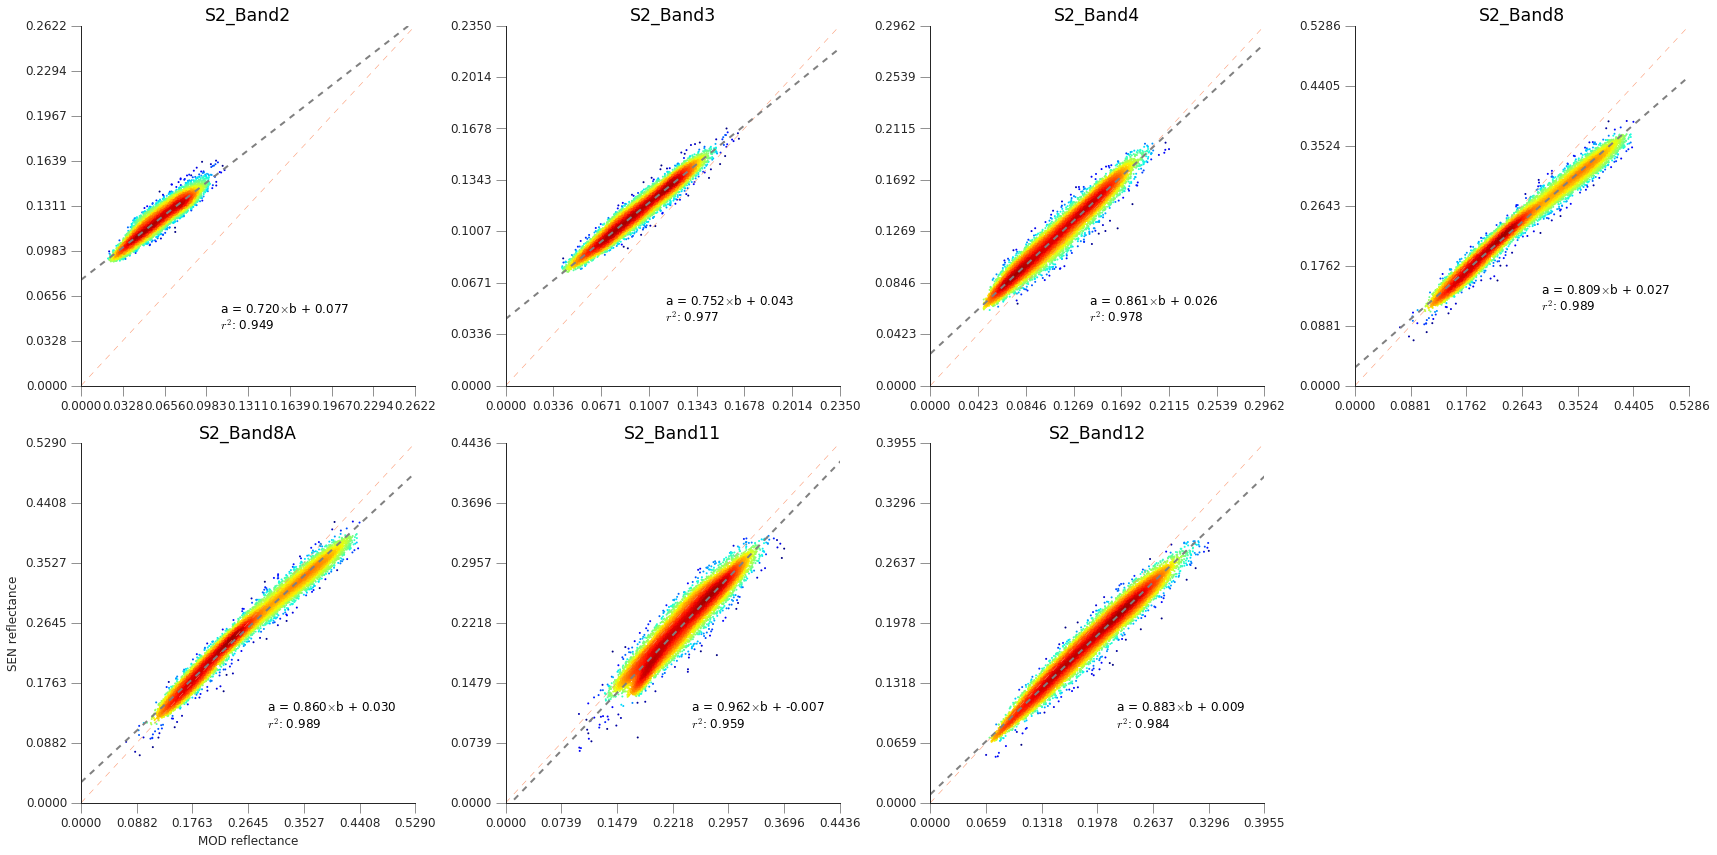

In [130]:
titles='S2_Band2','S2_Band3','S2_Band4','S2_Band8','S2_Band8A','S2_Band11','S2_Band12'
density_regression(to_cor[3], to_cor[2], cmap=cmap, titles=titles)
plt.savefig('50SKG_4_13.pdf', dpi=400)

In [26]:
S2_emulation = pkl.load(open('6S_emulation_S2.pkl', 'r'))
aot = read_net(2016, 4,13, np.arange(lat,lat+1, 0.125), np.arange(lon,lon+2, 0.125), dataset='aot')
twv = read_net(2016, 4,13, np.arange(lat,lat+1, 0.125), np.arange(lon,lon+2, 0.125), dataset='wv')
tco = read_net(2016, 4,13, np.arange(lat,lat+1, 0.125), np.arange(lon,lon+2, 0.125), dataset='tco')

In [46]:
import gdal
def elevation(lat, lon, north=True, east=True):
    lats = range( int(lat.min()), int(lat.max())+1)
    lons = range( int(lon.min()), int(this_lon.max())+1)
    eles=np.zeros_like(lat)
    for lat0 in lats:
        for lon0 in lons:
            if lat0>=0:
                lat_name = 'N%d'%int(lat0)
            elif lat0<0:
                lat_name = 'S%d'%int(lat0)
            else:
                'Wrong lat given, and float is expected!'
            if lon0>=0:
                lon_name = 'E%d'%int(lon0)
            elif lon0<0:
                lon_name = 'W%d'%int(lon0)
            else:
                'Wrong lon given, and float is expected!'
            fname = 'SRTM/'+lat_name+lon_name+ '.hgt'
            mask = (lat>lat0)&(lat<lat0+1)&(lon>lon0)&(lon<lon0+1)
            g = gdal.Open(fname)
            geo = g.GetGeoTransform()
            l_lon, lon_size,l_lat, lat_size, = geo[0], geo[1],geo[3],geo[5]
            x, y = ((lon-l_lon)/lon_size).astype(int), ((lat-l_lat)/lat_size).astype(int)
            ele = g.ReadAsArray()
            eles[mask] = ele[x[mask],y[mask]]    
    return eles

def cost(p, args = None):
    if any(p>10) or any(p<0):
        return 10000
    else:
        #'aot550', 'water', 'ozone'
        aot550, water = p
        TOA_refs, M_refs, angles, ele, ozone = args        
        sz, sa, vz, va = angles        
        Sur_refs = [S2_emulation[ind][0].predict(np.array([[toa_ref, aot550, water, ozone, \
                                                            np.sin(sz[ind]), np.sin(vz[ind]), np.cos((sa-va)[ind]), \
                                                            ele],]))[0][0] for ind, toa_ref in enumerate(TOA_refs)]
        Sur_refs = np.array(Sur_refs)
        M_refs = np.array(M_refs)
        cost = sum(abs(Sur_refs-M_refs)*w)    
        return cost


def opt(ind):
    
    #sent_refs, modis_refs = np.array([refs[ii][tuple(aoi[ind])] for ii in range(7)]).T
    
    TOA_refs = to_cor[2][:,ind]
    M_refs = to_cor[3][:,ind]
    m = mgrs.MGRS()
    pix_lat, pix_lon = m.toLatLon(mg_coor[:5]+'%04d%04d'%(to_cor[0][ind], to_cor[1][ind]))
    ele = eles[ind]
    inx_lat, inx_lon = (np.abs(lats-pix_lat)).argmin(),(np.abs(lons-pix_lon)).argmin()
    aot0, tcw0, tco0 = aot[inx_lat, inx_lon], twv[inx_lat, inx_lon]/10., tco[inx_lat, inx_lon]
                                                          
    angles =[i*np.pi/180 for i in [sza, saa, vza, vaa]]
    
    ozone = tco0*46.698
    
    args = TOA_refs, M_refs , angles, ele, ozone
    #print args
    p = aot0, tcw0 
    psolve = optimize.fmin_l_bfgs_b(cost,p, iprint=-1, approx_grad=1, args=(args,))
    return [to_cor[0][ind],to_cor[1][ind],psolve]

wl=0.490,0.560,0.665,0.842,1.610,2.190,0.865
alpha = 1.42 #angstrom exponent for continental type aerosols
w = (np.array(wl)/wl[0])**(-alpha)
lats, lons = np.arange(lat,lat+1, 0.125), np.arange(lon,lon+2, 0.125)

In [47]:
ll, ul, lr, ur = m.toLatLon('50SMG0000000000'), m.toLatLon('50SMG0000099999'), m.toLatLon('50SMG9999900000'), m.toLatLon('50SMG9999999999')
dic = {'LL_LAT': ll[0],
       'LL_LON': ll[1],
       'LR_LAT': lr[0],
       'LR_LON': lr[1],
       'UL_LAT': ul[0],
       'UL_LON': ul[1],
       'UR_LAT': ur[0],
       'UR_LON': ur[1]}
corners = 10000, 10000

this_lat, this_lon = cor_inter(np.array([to_cor[0], to_cor[1]]), dic, corners)
eles = elevation(this_lat, this_lon)/1000.

In [50]:
pool = multiprocessing.Pool(processes=16)
retval = pool.map(opt, range(len(to_cor[0])))
pool.close()
pool.join()

In [151]:
parallel_rw_pkl(retval, 'First_full_S2_aot', 'w')

Length of data: 7
Length of data: 7


In [33]:
import gdal
def elevation(lat, lon, north=True, east=True):
    lats = range( int(this_lat.min()), int(this_lat.max())+1)
    lons = range( int(this_lon.min()), int(this_lon.max())+1)
    eles=np.zeros_like(lat)
    for lat0 in lats:
        for lon0 in lons:
            if lat0>=0:
                lat_name = 'N%d'%int(lat0)
            elif lat0<0:
                lat_name = 'S%d'%int(lat0)
            else:
                'Wrong lat given, and float is expected!'
            if lon0>=0:
                lon_name = 'E%d'%int(lon0)
            elif lon0<0:
                lon_name = 'W%d'%int(lon0)
            else:
                'Wrong lon given, and float is expected!'
            fname = 'SRTM/'+lat_name+lon_name+ '.hgt'
            mask = (lat>lat0)&(lat<lat0+1)&(lon>lon0)&(lon<lon0+1)
            g = gdal.Open(fname)
            geo = g.GetGeoTransform()
            l_lon, lon_size,l_lat, lat_size, = geo[0], geo[1],geo[3],geo[5]
            x, y = ((lon-l_lon)/lon_size).astype(int), ((lat-l_lat)/lat_size).astype(int)
            ele = g.ReadAsArray()
            eles[mask] = ele[x[mask],y[mask]]    
    return eles
def cost(p, args = None):
    #if any(p>10) or any(p<0):
    #    return 10000,np.zeros(2)
    #else:
        #'aot550', 'water'
        aot550, water = p
        angles, ele, ozone = args        
        sz, sa, vz, va = angles        
        pas = [to_cor[2], aot550, water, ozone, np.sin(sz), np.sin(vz), np.cos(sa-va), ele]
        
        paras =  np.zeros((7, len(to_cor[2][0]), 8))
        for i in range(8):
            paras[:,:,i]=  pas[i]

        J = 0
        J_prime = np.zeros(2)
        for i in range(6):
            fwd, grad = L8_emus[i][0].predict(paras[i], do_unc=0)
            # select from set of gradients
            g0,g1 = grad[:,1],grad[:,2]
            #
            residual = np.array(fwd-to_cor[3][i])
            J_prime_wrt0_i = w[i] * residual * g0 
            J_prime_wrt1_i = w[i] * residual * g1
            J_i = 0.5 * w[i] * (residual**2)[:].sum()
            
            J += J_i
            J_prime += np.array([J_prime_wrt0_i,J_prime_wrt1_i])[:,:].sum(axis=1)
            
        return J , J_prime

def opt():
    
    this_lat, this_lon = cor_inter(np.array([to_cor[0], to_cor[1]]), dic, corners)
    ele = elevation(this_lat, this_lon)/1000.
                                                          
    angles =[i*np.pi/180 for i in [sza, saa, vza, vaa]]
    args = angles, 0.002, 0.41
    bounds = ((0.,None),(0.,None))
    
    p0 = 0.26719189382314973, 0.71375003926591296
    
    psolve = optimize.fmin_l_bfgs_b(cost,p0, approx_grad=0, iprint=1, bounds=bounds,fprime=None,args=(args,))
    this_lat, this_lon = cor_inter(np.array(zip(to_cor[0], to_cor[1])).T,  dic, corners)
    ele = elevation(this_lat, this_lon)/1000.
    
    #inx_lat, inx_lon = (np.abs(lats-this_lat)).argmin(),(np.abs(lons-this_lon)).argmin()
    #aot0, tcw0, tco0 = aot[inx_lat, inx_lon], twv[inx_lat, inx_lon]/10., tco[inx_lat, inx_lon]
                                                          
    angles =[i*np.pi/180 for i in [sza, saa, vza, vaa]]
    
    ozone = 0.36904032414188315
    
    args = TOA_refs, M_refs , angles, ele, ozone
    
    return psolve



wl = np.array([482.04,561.41,654.59,864.67,1608.86,2200.73])/1000
alpha = 1.42 #angstrom exponent for continental type aerosols
w = (np.array(wl)/wl[0])**(-alpha)
#w = 1/aot_grad.mean(axis=1)
#w = (w**3+w[::-1]**3)/2

In [36]:
ll, ul, lr, ur = m.toLatLon('50SMG0000000000'), m.toLatLon('50SMG0000099999'), m.toLatLon('50SMG9999900000'), m.toLatLon('50SMG9999999999')
dic = {'LL_LAT': ll[0],
       'LL_LON': ll[1],
       'LR_LAT': lr[0],
       'LR_LON': lr[1],
       'UL_LAT': ul[0],
       'UL_LON': ul[1],
       'UR_LAT': ur[0],
       'UR_LON': ur[1]}
corners = 10000, 10000

In [148]:
ao = parallel_rw_pkl(None, 'S2_50SKG_104_aot', 'r')

In [209]:
indx, indy = np.array([[i[0], i[1]] for i in ao]).astype(int).T

In [150]:
paras = np.array([i[2][0] for i in ao])

(0.0, 0.4)

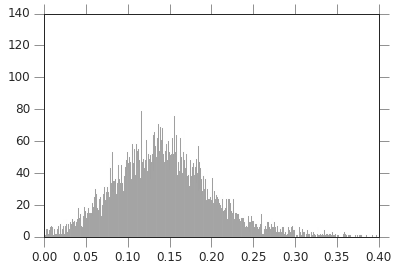

In [168]:
hist = plt.hist(paras[:,0], bins=1000, color='grey', lw=0.1, alpha=0.8)
plt.xlim(0.,0.4)

In [181]:
paras[:,0].mean()+ 1.69*paras[:,0].std(), paras[:,0].mean()- 1.69*paras[:,0].std()

(0.25023396536343839, 0.036979559735815778)

In [169]:
cost = np.array([i[2][1] for i in ao])

In [202]:
wm = sum(paras[:,0]*(1./cost))/(1./cost).sum()
wstd = np.sqrt(sum((1./cost)*(paras[:,0]-wm)**2)/(1./cost).sum()*(len(cost)/(len(cost)-1)))
wm, wstd

(0.1503235316336006, 0.064369737277052475)

In [205]:
0.1503235316336006+ 1.69*0.064369737277052475, 0.1503235316336006- 1.69*0.064369737277052475

(0.25910838763181926, 0.041538675635381925)

In [218]:
aot_in = (paras[:,0]>(wm-1.69*wstd)) & (paras[:,0]<(wm+1.69*wstd))

In [219]:
indx[aot_in], indy[aot_in]

(array([  60,   61,   63, ..., 9996, 9998, 9999]),
 array([5693, 5740, 5786, ..., 3685, 3731, 3778]))

In [220]:
aot_map = np.zeros((10980, 10980))
aot_map[:] = wm
aot_map[indx[aot_in], indy[aot_in]]= paras[aot_in, 0]

In [ ]:
w = np.zeros_like(aot_map)
w[indx[aot_in], indy[aot_in]]=1

In [229]:
smmothed = ndimage.filters.gaussian_filter(aot_map, 100)

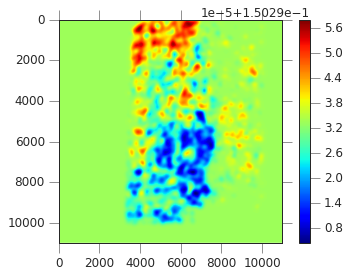

In [230]:
plt.imshow(smmothed, interpolation='None')
plt.colorbar()

In [235]:
patch = aot_map[4000:6000, 4000:6000]

In [242]:
r_smed = smoothn(patch, W=w[4000:6000, 4000:6000], s=20, isrobust=True)

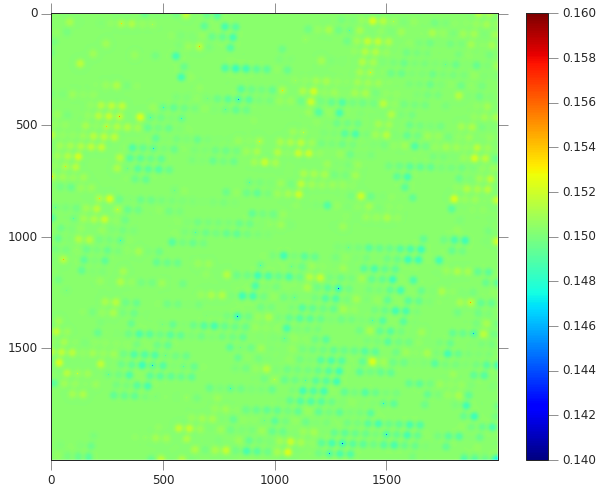

In [246]:
plt.figure(figsize=(10,8))
plt.imshow(r_smed[0], interpolation='None', vmin=0.14, vmax=0.16)
plt.colorbar()

In [269]:
import gdal
def elevation(lat, lon, north=True, east=True):
    lats = range( int(lat.min()), int(lat.max())+1)
    lons = range( int(lon.min()), int(lon.max())+1)
    eles=np.zeros_like(lat)
    for lat0 in lats:
        for lon0 in lons:
            if lat0>=0:
                lat_name = 'N%d'%int(lat0)
            elif lat0<0:
                lat_name = 'S%d'%int(lat0)
            else:
                'Wrong lat given, and float is expected!'
            if lon0>=0:
                lon_name = 'E%d'%int(lon0)
            elif lon0<0:
                lon_name = 'W%d'%int(lon0)
            else:
                'Wrong lon given, and float is expected!'
            fname = 'SRTM/'+lat_name+lon_name+ '.hgt'
            mask = (lat>lat0)&(lat<lat0+1)&(lon>lon0)&(lon<lon0+1)
            g = gdal.Open(fname)
            geo = g.GetGeoTransform()
            l_lon, lon_size,l_lat, lat_size, = geo[0], geo[1],geo[3],geo[5]
            x, y = ((lon-l_lon)/lon_size).astype(int), ((lat-l_lat)/lat_size).astype(int)
            ele = g.ReadAsArray()
            eles[mask] = ele[x[mask],y[mask]]    
    
    return eles

def cost(p, args = None):
    aot550, water = p
    angles, ele, ozone = args        
    sz, sa, vz, va = angles        
    pas = [to_cor[2], aot550, water, ozone, np.sin(sz), np.sin(vz), np.cos(sa-va), ele]

    paras =  np.zeros((len(bands), len(to_cor[2][0]), 8))
    for i in range(8):
        if np.array(pas[i]).shape==(7,):
            dat = np.repeat(pas[1], axis=0, repeats=len(to_cor[2][0]))
            paras[:,:,i] =  dat
        else:
            paras[:,:,i] =  pas[i]

    J = 0
    J_prime = np.zeros(2)
    for i in range(6):
        fwd, grad = S2_emulation[i][0].predict(paras[i], do_unc=0)
        # select from set of gradients
        g0,g1 = grad[:,1],grad[:,2]
        #
        residual = np.array(fwd-to_cor[3][i])
        J_prime_wrt0_i = w[i] * residual * g0 
        J_prime_wrt1_i = w[i] * residual * g1
        J_i = 0.5 * w[i] * (residual**2)[:].sum()

        J += J_i
        J_prime += np.array([J_prime_wrt0_i,J_prime_wrt1_i])[:,:].sum(axis=1)

    return J , J_prime

def opt():
    
    this_lat, this_lon = cor_inter(np.array([to_cor[0], to_cor[1]]), dic, corners)
    ele = elevation(this_lat, this_lon)/1000.
                                                          
    angles =[i*np.pi/180 for i in [sza, saa, vza, vaa]]
    args = angles, 0.002, 0.41
    bounds = ((0.,None),(0.,None))
    
    p0 = 0.18879667014183876, 0.21850598135653616
    
    psolve = optimize.fmin_l_bfgs_b(cost,p0, approx_grad=0, iprint=1, bounds=bounds,fprime=None,args=(args,))
    this_lat, this_lon = cor_inter(np.array(zip(to_cor[0], to_cor[1])).T,  dic, corners)
    ele = elevation(this_lat, this_lon)/1000.
    return psolve

alpha = 1.42 #angstrom exponent for continental type aerosols
w = (np.array(wl)/wl[0])**(-alpha)

In [350]:
s = S_data.copy()
Mcomb_mask = np.all(qa<2, axis=0)
Scomb_mask = np.all(S_mask, axis = 0)
s[:,(~Scomb_mask)|(~Mcomb_mask[val])]=np.nan
s[np.isnan(s)], brdf[np.isnan(brdf)] = -9999999, -9999999
mas = np.all((brdf[:,val]>0)&(brdf[:,val]<1)&(s>0)&(s<1), axis=0)
to_cor = shx[val][mas], shy[val][mas],s[:,mas], brdf[:,val][:,mas]

In [397]:
qa

(7, 30337)

In [428]:
import gdal
from scipy import optimize
def elevation(lat, lon, north=True, east=True):
    lats = range( int(lat.min()), int(lat.max())+1)
    lons = range( int(lon.min()), int(lon.max())+1)
    eles=np.zeros_like(lat)
    for lat0 in lats:
        for lon0 in lons:
            if lat0>=0:
                lat_name = 'N%d'%int(lat0)
            elif lat0<0:
                lat_name = 'S%d'%int(lat0)
            else:
                'Wrong lat given, and float is expected!'
            if lon0>=0:
                lon_name = 'E%d'%int(lon0)
            elif lon0<0:
                lon_name = 'W%d'%int(lon0)
            else:
                'Wrong lon given, and float is expected!'
            fname = 'SRTM/'+lat_name+lon_name+ '.hgt'
            mask = (lat>lat0)&(lat<lat0+1)&(lon>lon0)&(lon<lon0+1)
            g = gdal.Open(fname)
            geo = g.GetGeoTransform()
            l_lon, lon_size,l_lat, lat_size, = geo[0], geo[1],geo[3],geo[5]
            x, y = ((lon-l_lon)/lon_size).astype(int), ((lat-l_lat)/lat_size).astype(int)
            ele = g.ReadAsArray()
            eles[mask] = ele[x[mask],y[mask]]    
    
    return eles

def cost(p, args = None):
    aot550, water = p
    angles, ele, ozone, mask = args        
    sz, sa, vz, va = angles        
    pas = [to_cor[2][:,mask], aot550, water, ozone, np.sin(sz), np.sin(vz), np.cos(sa-va), ele]

    paras =  np.zeros((len(bands), len(to_cor[2][0, mask]), 8))
    for i in range(8):
        if np.array(pas[i]).shape==(7,):
            dat = np.repeat(pas[1], axis=0, repeats=len(to_cor[2][0, mask]))
            paras[:,:,i] =  dat
        else:
            paras[:,:,i] =  pas[i]

    J = 0
    J_prime = np.zeros(2)
    for i in range(6):
        fwd, grad = S2_emulation[i][0].predict(paras[i], do_unc=0)
        # select from set of gradients
        g0,g1 = grad[:,1],grad[:,2]
        #
        residual = np.array(fwd-to_cor[3][i, mask])
        J_prime_wrt0_i = w[i] * residual * g0 
        J_prime_wrt1_i = w[i] * residual * g1
        J_i = 0.5 * w[i] * (residual**2)[:].sum()

        J += J_i
        J_prime += np.array([J_prime_wrt0_i,J_prime_wrt1_i])[:,:].sum(axis=1)

    return J , J_prime

def opt(i,j, mask):
    
    px, py = np.mgrid[i*500: (i+1)*500, j*500: (j+1)*500]
    this_lat, this_lon = cor_inter(np.array([px.ravel(), py.ravel()]), dic, corners)
    ele = mean(elevation(this_lat, this_lon)/1000.)
    #ele = 0.002                                                      
    angles =[i*np.pi/180 for i in [sza, saa, vza, vaa]]
    args = angles, 0.002, 0.41, mask
    bounds = ((0.,None),(0.,None))
    
    p0 = 0.18879667014183876, 0.21850598135653616
    
    psolve = optimize.fmin_l_bfgs_b(cost,p0, approx_grad=0, iprint=1, bounds=bounds,fprime=None,args=(args,))
    #this_lat, this_lon = cor_inter(np.array(zip(to_cor[0][mask], to_cor[1][mask])).T,  dic, corners)
    #ele = elevation(this_lat, this_lon)/1000.
    return psolve

alpha = 1.42 #angstrom exponent for continental type aerosols
w = (np.array(wl)/wl[0])**(-alpha)

In [ ]:
n

In [288]:
i, j = 8,8
indx, indy = to_cor[:2]
mask = (indx>i*500) & (indx<(i+1)*500) & (indy>j*500) & (indy<(j+1)*500)

In [ ]:
patches = []
inds = []
indx, indy = to_cor[:2]
for i in range(0, 20):
    for j in range(0, 20):
        mask = (indx>i*500) & (indx<(i+1)*500) & (indy>j*500) & (indy<(j+1)*500)
        patches.append(opt(i,j,mask))
        inds.append([i,j])

In [430]:
inds = np.array(inds)
inds

array([[ 0,  0],
       [ 0,  1],
       [ 0,  2],
       [ 0,  3],
       [ 0,  4],
       [ 0,  5],
       [ 0,  6],
       [ 0,  7],
       [ 0,  8],
       [ 0,  9],
       [ 0, 10],
       [ 0, 11],
       [ 0, 12],
       [ 0, 13],
       [ 0, 14],
       [ 0, 15],
       [ 0, 16],
       [ 0, 17],
       [ 0, 18],
       [ 0, 19],
       [ 1,  0],
       [ 1,  1],
       [ 1,  2],
       [ 1,  3],
       [ 1,  4],
       [ 1,  5],
       [ 1,  6],
       [ 1,  7],
       [ 1,  8],
       [ 1,  9],
       [ 1, 10],
       [ 1, 11],
       [ 1, 12],
       [ 1, 13],
       [ 1, 14],
       [ 1, 15],
       [ 1, 16],
       [ 1, 17],
       [ 1, 18],
       [ 1, 19],
       [ 2,  0],
       [ 2,  1],
       [ 2,  2],
       [ 2,  3],
       [ 2,  4],
       [ 2,  5],
       [ 2,  6],
       [ 2,  7],
       [ 2,  8],
       [ 2,  9],
       [ 2, 10],
       [ 2, 11],
       [ 2, 12],
       [ 2, 13],
       [ 2, 14],
       [ 2, 15],
       [ 2, 16],
       [ 2, 17],
       [ 2, 18

In [431]:
paras = np.array([i[0] for i in patches])
paras

array([[ 0.18879667,  0.21850598],
       [ 0.18879667,  0.21850598],
       [ 0.18879667,  0.21850598],
       [ 0.18879667,  0.21850598],
       [ 0.18879667,  0.21850598],
       [ 0.18879667,  0.21850598],
       [ 0.18879667,  0.21850598],
       [ 0.29637908,  0.22471011],
       [ 0.29312069,  0.22947702],
       [ 0.27986508,  0.2315586 ],
       [ 0.28587321,  0.23128846],
       [ 0.27944157,  0.22601904],
       [ 0.30170211,  0.22543586],
       [ 0.31152609,  0.22161191],
       [ 0.28481432,  0.23647163],
       [ 0.29565369,  2.36052252],
       [ 0.3375646 ,  0.23495794],
       [ 0.35855387,  1.94965987],
       [ 0.35957149,  0.23603742],
       [ 0.33010203,  0.24204791],
       [ 0.18879667,  0.21850598],
       [ 0.18879667,  0.21850598],
       [ 0.18879667,  0.21850598],
       [ 0.18879667,  0.21850598],
       [ 0.18879667,  0.21850598],
       [ 0.18879667,  0.21850598],
       [ 0.18879667,  0.21850598],
       [ 0.28460235,  0.23135227],
       [ 0.30105606,

In [432]:
paras[:,0].mean(), paras[:,0].std()

(0.2587572842356663, 0.053062015948100776)

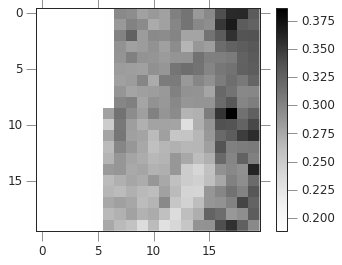

In [435]:
aot_map = np.zeros((20,20))
aot_map[inds[:,0].astype(int), inds[:,1].astype(int)] = paras[:,0]
plt.imshow(aot_map, interpolation='None', cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()

In [477]:
aot_map[cost==0] = aot_map[cost!=0].mean()

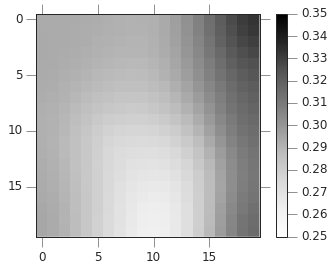

In [488]:
#cost = np.array([i[1] for i in patches]).reshape(18,18)
smed_aot = smoothn(aot_map, s=1, W=w*1000, isrobust=True)
plt.imshow(smed_aot[0], interpolation='None', cmap=plt.cm.get_cmap('Greys'), vmin=0.25, vmax=0.35)
plt.colorbar()

In [461]:
w = np.zeros_like(cost)
w[cost!=0] = 1./cost[cost!=0]

In [437]:
paras[:,1].mean(), paras[:,1].std()

(0.70595507070773877, 1.0988644457870005)

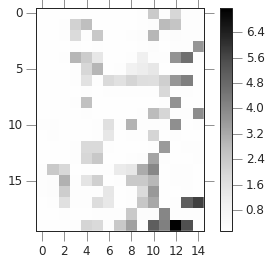

In [440]:
wv_map = np.zeros((20,20))
wv_map[inds[:,0].astype(int), inds[:,1].astype(int)] = paras[:,1]
plt.imshow(wv_map[:,5:], interpolation='None', cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()

In [481]:
wv_map[cost!=0].mean()

0.9379880320594185

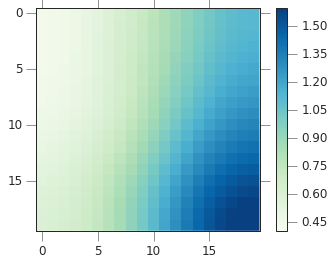

In [486]:
cost = np.array([i[1] for i in patches]).reshape(20,20)
wv_map[cost==0] = wv_map[cost!=0].mean()
smed_wv = smoothn(wv_map, s=5, W=w*1000, isrobust=True)
plt.imshow(smed_wv[0], interpolation='None', cmap=plt.cm.get_cmap('GnBu'), vmin=0.4, vmax=1.6)
plt.colorbar()